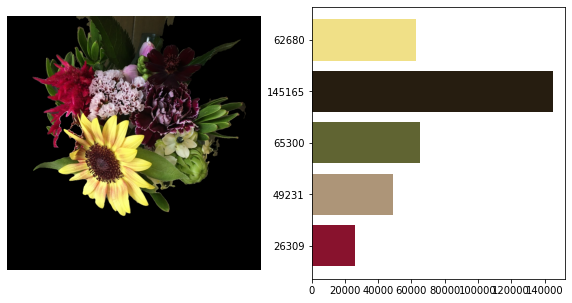

In [120]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# load image, change color spaces, and smoothing
img = cv2.imread('sample1.jpeg')
img_HSV = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
cv2.imwrite('files/cvt_color.jpg', img_HSV)
img_HSV = cv2.GaussianBlur(img_HSV, (9, 9), 3)
cv2.imwrite('files/blur.jpg', img_HSV)

# detect tulips
img_H, img_S, img_V = cv2.split(img_HSV)
_thre, img_flowers = cv2.threshold(img_S, 90, 255, cv2.THRESH_BINARY)
cv2.imwrite('files/mask.jpg', img_flowers)

# find tulips
contours, hierarchy = cv2.findContours(img_flowers, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
# contours, hierarchy = cv2.findContours(img_flowers, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)


# sort area
contours.sort(key=lambda x: cv2.contourArea(x), reverse=True)

# all area
# for i in range(0, len(contours)):
#     if len(contours[i]) > 0:
#         # remove small objects
#         if cv2.contourArea(contours[i]) < 500:
#             continue

#         rect = contours[i]
#         x, y, w, h = cv2.boundingRect(rect)
#         cv2.rectangle(img, (x, y), (x + w, y + h), (255, 255, 255), 2)

# max area
rect = contours[0]
x, y, w, h = cv2.boundingRect(rect)
# cv2.rectangle(img, (x, y), (x + w, y + h), (255, 255, 255), 2)
# save
# cv2.imwrite('files/boundingbox.jpg', img)

# ROI 領域以外をマスクする。
mask = np.zeros_like(img)
cv2.drawContours(mask, [rect], -1, color=(255, 255, 255), thickness=-1)
masked = img & mask

# # エリア外をマスクする場合
# stencil = np.zeros(img.shape).astype(img.dtype)
# contours = [np.array([[x, y], [x + w, y], [x + w, y + h], [x, y + h]])]
# color = [255, 255, 255]
# cv2.fillPoly(stencil, contours, color)
# masked = cv2.bitwise_and(img, stencil)

# 色一覧
colors = masked.reshape(-1, 3)
colors = colors[(colors != 0).all(axis=1)]  # 黒は除く

# k平均法でクラスタリングする。
k = 5
criteria = cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0
ret, label, center = cv2.kmeans(
    colors.astype(np.float32), k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS
)

# 円の中に含まれる代表色 Top5 を可視化する。
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 5))
# 各クラスに属するサンプル数を計算する。
height = [np.count_nonzero(label == i) for i in range(k)]
# 各クラスの色を取得する。matplotlib の引数の仕様上、[0, 1] にして、(R, G, B) の順番にする。
rep_color = (center / 255)[:, ::-1]

# 画像を表示する。
ax1.imshow(cv2.cvtColor(masked, cv2.COLOR_BGR2RGB))
ax1.set_axis_off()

# ヒストグラムを表示する。
ax2.barh(np.arange(k), height, color=rep_color, tick_label=height)
plt.show()